In [1]:
import os, sys, time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None
import h5py
import geopandas as gpd
import toml
config = toml.load('../../../configuration/input_configuration.toml')
os.sys.path.append(os.path.join(os.getcwd(),r'..\standard'))
sys.path.append(os.path.join(os.getcwd(),r'..\..\..'))
# import summary_helpers

%matplotlib inline

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

# Relative path between notebooks and goruped output directories
relative_path = '../../../outputs'
survey_path = '../../../inputs/base_year/survey'

In [3]:
pd.options.display.float_format = '{:0,.0f}'.format

In [4]:
def load_network_summary(filepath):
    """Load network-level results using a standard procedure. """
    df = pd.read_csv(filepath)

    # Congested network components by time of day
    df.columns

    # Get freeflow from 20to5 period

    # Exclude trips taken on non-designated facilities (facility_type == 0)
    # These are artificial (weave lanes to connect HOV) or for non-auto uses 
    df = df[df['data3'] != 0]    # data3 represents facility_type

    # calculate total link VMT and VHT
    df['VMT'] = df['@tveh']*df['length']
    df['VHT'] = df['@tveh']*df['auto_time']/60

    # Define facility type
    df.loc[df['data3'].isin([1,2]), 'facility_type'] = 'highway'
    df.loc[df['data3'].isin([3,4,6]), 'facility_type'] = 'arterial'
    df.loc[df['data3'].isin([5]), 'facility_type'] = 'connector'

    # Calculate delay
    # Select links from overnight time of day
    delay_df = df.loc[df['tod'] == '20to5'][['ij','auto_time']]
    delay_df.rename(columns={'auto_time':'freeflow_time'}, inplace=True)

    # Merge delay field back onto network link df
    df = pd.merge(df, delay_df, on='ij', how='left')

    # Calcualte hourly delay
    df['total_delay'] = ((df['auto_time']-df['freeflow_time'])*df['@tveh'])/60    # sum of (volume)*(travtime diff from freeflow)

    df['county'] =df['@countyid'].map({33: 'King',
                                      35: 'Kitsap',
                                      53: 'Pierce',
                                      61: 'Snohomish'})
    
    return df

# Truck Miles Traveled by Type
Daily Total

In [5]:
df = load_network_summary(os.path.join(relative_path,'network',r'network_results.csv'))
df['medium_truck_vmt'] = df['@mveh']*df['length']
df['heavy_truck_vmt'] = df['@hveh']*df['length']

In [6]:
_df = df.groupby('county').sum()[['medium_truck_vmt','heavy_truck_vmt']]
_df.loc['Total',:] = _df.sum()
_df = _df.reset_index()
_df.rename(columns={'county':'County', 'medium_truck_vmt': 'Medium Trucks', 'heavy_truck_vmt': 'Heavy Trucks'}, inplace=True)
_df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\RTP','truck_vmt.csv'))
HTML(_df.to_html(index=False))

County,Medium Trucks,Heavy Trucks
King,"2,124,762","1,540,960"
Kitsap,"184,845","97,681"
Pierce,"616,739","605,194"
Snohomish,"609,637","584,420"
Total,"3,535,983","2,828,256"


In [7]:
# Results by Congestion Level
df['speed'] = df['length']/df['auto_time']*60
df['congestion_index'] = df['speed']/df['data2']
df['congestion_index'] = df['congestion_index'].clip(0,1)
df['congestion_category'] = pd.cut(df['congestion_index'], bins=[0,.25,.5,.7,1], labels=['Severe','Heavy','Moderate','Light'])

AM Peak (5 - 9 am)

In [8]:
df['Medium and Heavy Trucks'] = df['heavy_truck_vmt']+df['medium_truck_vmt']

_df = df[df['tod'].isin(['5to6','6to7','7to8','8to9'])]
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='Medium and Heavy Trucks')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df.loc['Total',:] = _df.sum()
_df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\RTP','truck_vmt_am.csv'))
_df

,King,Kitsap,Pierce,Snohomish
Light,"552,421","55,826","210,829","217,098"
Moderate,"137,290",640,"38,451","25,874"
Heavy,"84,418","1,159","9,130","10,833"
Severe,"5,145",28,360,426
Total,"779,273","57,653","258,769","254,231"


PM Peak (3 - 6 pm)

In [9]:
_df = df[df['tod'].isin(['15to16','16to17','17to18'])]
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='Medium and Heavy Trucks')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df.loc['Total',:] = _df.sum()
_df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\RTP','truck_vmt_pm.csv'))
_df

,King,Kitsap,Pierce,Snohomish
Light,"454,805","47,657","173,893","178,980"
Moderate,"131,337",803,"34,316","29,724"
Heavy,"79,519",610,"11,930","8,743"
Severe,"6,500",50,499,491
Total,"672,161","49,120","220,637","217,938"


# Share of Truck Miles by Truck Type
Daily Total

In [10]:
_df = df[['medium_truck_vmt','heavy_truck_vmt','county']].melt(
    id_vars='county', var_name='Truck Type')
_df = _df.pivot_table(index='Truck Type', columns='county', 
                values='value', aggfunc='sum')
_df.rename(index={'heavy_truck_vmt': 'Heavy Trucks',
                 'medium_truck_vmt': 'Medium Trucks'}, inplace=True)
_df.index.name = None
_df.columns.name = None
_df.sort_index(ascending=False, inplace=True)
_df_val = _df.copy()
_df.loc['Total',:] = _df.sum()
_df

,King,Kitsap,Pierce,Snohomish
Medium Trucks,"2,124,762","184,845","616,739","609,637"
Heavy Trucks,"1,540,960","97,681","605,194","584,420"
Total,"3,665,722","282,526","1,221,933","1,194,057"


In [11]:
pd.options.display.float_format = '{:0,.1%}'.format
_df_val/_df_val.sum()

,King,Kitsap,Pierce,Snohomish
Medium Trucks,58.0%,65.4%,50.5%,51.1%
Heavy Trucks,42.0%,34.6%,49.5%,48.9%


# Truck Miles on FGTS
Freight and Goods Transportation System
- T-1: More than 10 million tons per year
- T-2: 2 4 million to 10 million tons per year

In [12]:
df['Non-Truck'] = df['VMT']-df['Medium and Heavy Trucks']
# df['@tveh'].sum()
df['VMT'].sum()

84116442.4401759

In [13]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df[['medium_truck_vmt','heavy_truck_vmt','@fgts','Non-Truck']].melt(
    id_vars='@fgts', var_name='Vehicle Type')
_df = _df.pivot_table(index='Vehicle Type', columns='@fgts', 
                values='value', aggfunc='sum')
# _df = _df.reset_index()
_df = _df.rename_axis(None, axis=1)
_df.rename(columns={0:'Other Routes', 1: 'T-1', 2: 'T-2'}, inplace=True)
_df.rename(index={'heavy_truck_vmt': 'Heavy Trucks',
                 'medium_truck_vmt': 'Medium Trucks'}, inplace=True)
_df[['T-1','T-2','Other Routes']]

,T-1,T-2,Other Routes
Vehicle Type,,,
Non-Truck,"29,602,653","11,818,838","36,304,980"
Heavy Trucks,"2,281,641","190,877","381,303"
Medium Trucks,"1,955,685","545,670","1,034,796"


In [14]:
pd.options.display.float_format = '{:0,.1%}'.format
_df[['T-1','T-2','Other Routes']]/_df[['T-1','T-2','Other Routes']].sum()

,T-1,T-2,Other Routes
Vehicle Type,,,
Non-Truck,87.5%,94.1%,96.2%
Heavy Trucks,6.7%,1.5%,1.0%
Medium Trucks,5.8%,4.3%,2.7%


In [15]:
pd.options.display.float_format = '{:0,.0f}'.format

# Truck Congestion on FGTS
AM Peak (5 - 9 am)

In [16]:
# Congested Miles on FGTS versus other Routes
df['Medium and Heavy Trucks'] = df['@mveh']+df['@hveh']

_df = df[df['tod'].isin(['5to6','6to7','7to8','8to9'])]
_df = _df.pivot_table(index='congestion_category',columns='@fgts',
               aggfunc='sum',values='Medium and Heavy Trucks')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df.rename(columns={0:'Other Routes', 1: 'T-1', 2: 'T-2'}, inplace=True)
_df_ = _df.copy()
_df.loc['Total',:] = _df.sum()
_df = _df[['T-1','T-2','Other Routes']]
_df

,T-1,T-2,Other Routes
Light,"1,966,025","784,931","1,609,077"
Moderate,"468,004","100,831","196,365"
Heavy,"253,929","76,598","163,362"
Severe,"21,536","29,972","66,267"
Total,"2,709,494","992,332","2,035,071"


In [17]:
pd.options.display.float_format = '{:0,.1%}'.format
_df_/_df_.sum()

,Other Routes,T-1,T-2
Light,79.1%,72.6%,79.1%
Moderate,9.6%,17.3%,10.2%
Heavy,8.0%,9.4%,7.7%
Severe,3.3%,0.8%,3.0%


PM Peak (3 - 6 pm)

In [18]:
pd.options.display.float_format = '{:0,.0f}'.format
# Congested Miles on FGTS versus other Routes
df['Medium and Heavy Trucks'] = df['@hveh']+df['@mveh']

_df = df[df['tod'].isin(['15to16','16to17','17to18'])]
_df = _df.pivot_table(index='congestion_category',columns='@fgts',
               aggfunc='sum',values='Medium and Heavy Trucks')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df.rename(columns={0:'Other Routes', 1: 'T-1', 2: 'T-2'}, inplace=True)
_df_ = _df.copy()
_df.loc['Total',:] = _df.sum()
_df = _df[['T-1','T-2','Other Routes']]
_df

,T-1,T-2,Other Routes
Light,"1,577,450","654,968","1,358,615"
Moderate,"452,307","95,400","191,783"
Heavy,"229,020","73,600","163,117"
Severe,"32,194","31,681","66,509"
Total,"2,290,972","855,649","1,780,025"


In [19]:
pd.options.display.float_format = '{:0,.1%}'.format
_df_/_df_.sum()

,Other Routes,T-1,T-2
Light,76.3%,68.9%,76.5%
Moderate,10.8%,19.7%,11.1%
Heavy,9.2%,10.0%,8.6%
Severe,3.7%,1.4%,3.7%


# Households Within 500' of Heavy Truck Volumes
Total number of households within 500' of T-1 and T-2 routes
- T-1: More than 10 million tons per year
- T-2: 2 4 million to 10 million tons per year

In [20]:
# Intersect buffer with land use file
df_lu = pd.read_csv(r'..\..\..\inputs\scenario\landuse\parcels_urbansim.txt',
                   sep='\s+')

# Load as a geodataframe
gdf_lu = gpd.GeoDataFrame(
    df_lu, geometry=gpd.points_from_xy(df_lu.xcoord_p, df_lu.ycoord_p))

crs = {'init' : 'EPSG:2285'}
gdf_lu.crs = crs

# Buffer the parcels at 500ft
gdf_lu['geometry'] = gdf_lu.buffer(500)

In [21]:

# Intersect this geography  with the network shapefile
gdf_network = gpd.read_file(r'..\..\..\inputs\scenario\networks\shapefiles\AM\AM_edges.shp')
# Do not include connectors since these are abstracted ul3==5; also remove weave links ul3==0 
gdf_network = gdf_network[~gdf_network.ul3.isin([0,5])]
# Truck network links are those that are in FGTS 1 or 2 system
gdf_network = gdf_network[gdf_network['FGTS'].isin([1,2])]

gdf_intersect = gpd.overlay(gdf_network, gdf_lu, how="intersection", keep_geom_type=False)

# Will need to relaculate the lengths since some were split across the regional geographies
gdf_intersect['new_length'] = gdf_intersect.geometry.length/5280.0

# filter out the polygon results and only keep lines
gdf_intersect = gdf_intersect[gdf_intersect.geometry.type.isin(['MultiLineString','LineString'])]

<AxesSubplot:>

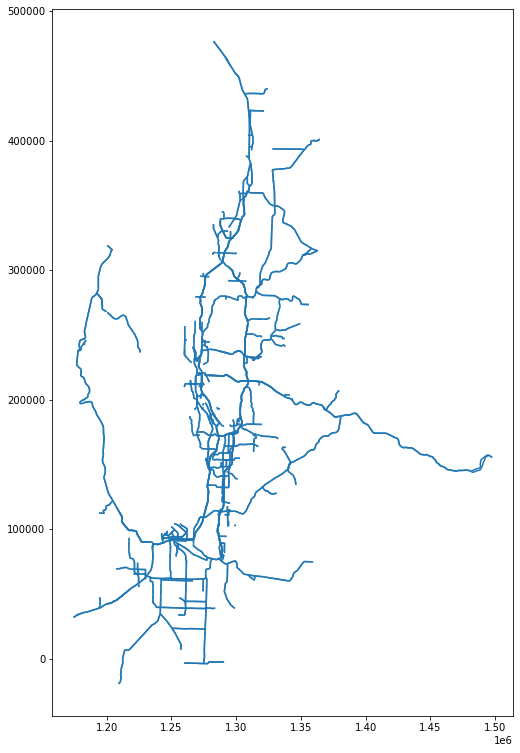

In [22]:
gdf_network.plot(figsize=(13,13))

In [23]:
truck_parcels = gdf_intersect.groupby('parcelid').first()[['hh_p']].reset_index()


# Result should be the network components with some flags for the parcelid
# We can take the parcel information, join with parcel info and group
# from input_configuration import base_year
import toml
config = toml.load(os.path.join(os.getcwd(),r'../../../configuration/input_configuration.toml'))

parcel_geog = pd.read_sql_table('parcel_'+config['base_year']+'_geography', 'sqlite:///../../../inputs/db/'+config['db_name'])
df = truck_parcels.merge(parcel_geog,left_on='parcelid', right_on='ParcelID')

In [24]:
# md("There are **{}** total households within 500 feet of all T-1 and T-2 routes".format(int(df['HH_P'].sum())))
# df['HH_P'].sum()

In [25]:
# md("This is **{}**% of total regional households".format(str((df['HH_P'].sum()/df_lu['HH_P'].sum())*100)[:5]))

In [26]:
# Get the total number of households that in equtiy geograhpies
# Comprae the percent of those that are in the buffer versus those that are not
# For the 4 equity groups, perform the calc and add as a table
results_df = pd.DataFrame()
for col, name in {'racial_geog_vs_reg_total': 'Race',
                  'poverty_geog_vs_reg_total': 'Poverty',
                  'elderly_geog_vs_reg_total': 'Elderly',
                  'youth_geog_vs_reg_total': 'Youth'}.items():
    _df = df.groupby(col).sum()[['hh_p']]
    _df['equity_group'] = name
    results_df = results_df.append(_df)
results_df = results_df.reset_index()


Total Households Within 500' of T-1/T-2 Routes by Equity Group

In [27]:
_df = results_df.pivot_table(index='index', columns='equity_group', values='hh_p', aggfunc='sum')
_df.index = ['Households Not in Equity Geography', 'Households in Equity Geography']

% of households within 500' of truck routes that are in/outside of equity geographies

In [28]:
pd.options.display.float_format = '{:0,.1%}'.format
_df/_df.sum()

equity_group,Elderly,Poverty,Race,Youth
Households Not in Equity Geography,60.4%,48.1%,37.5%,66.2%
Households in Equity Geography,39.6%,51.9%,62.5%,33.8%


In [29]:
pd.options.display.float_format = '{:0,.0f}'.format

# results_df.groupby(['equity_group','index']).sum()[['HH_P']]
_df = results_df.pivot_table(index='equity_group',columns='index',values='hh_p')
_df.rename(columns={0:'Not In Equity Group', 1: 'In Equity Group'}, inplace=True)
_df.index.name = None
_df.columns.name = None
_df['Total Households'] = _df.sum(axis=1)
_df_buffer = _df.copy()


In [30]:
df_lu_tot = df_lu[['parcelid','hh_p']].merge(parcel_geog,left_on='parcelid', right_on='ParcelID')
# df_lu_tot['region'] = 1
results_df_tot = pd.DataFrame()
for col, name in {'racial_geog_vs_reg_total': 'Race',
                  'poverty_geog_vs_reg_total': 'Poverty',
                  'elderly_geog_vs_reg_total': 'Elderly',
                  'youth_geog_vs_reg_total': 'Youth',
#                   'region': 'Regional Total',
                 }.items():
    _df = df_lu_tot.groupby(col).sum()[['hh_p']]
    _df['equity_group'] = name
    results_df_tot = results_df_tot.append(_df)
results_df_tot = results_df_tot.reset_index()
pd.options.display.float_format = '{:0,.0f}'.format

results_df_tot = results_df_tot[results_df_tot['index'] >= 0]
_df = results_df_tot.pivot_table(index='equity_group',columns='index',values='hh_p')
_df.rename(columns={0:'Not in Equity Group', 1: 'In Equity Group'}, inplace=True)
_df.index.name = None
_df.columns.name = None
_df['Total Households'] = _df.sum(axis=1)
_df_tot = _df.copy()


Percent of Households in Equity Group Also in the Buffer

In [31]:
_df = _df_tot.merge(_df_buffer, left_index=True, right_index=True, suffixes=['_tot','_buffer'])

pd.options.display.float_format = '{:0,.1%}'.format
_df_compare = pd.DataFrame(_df['In Equity Group_buffer']/_df['In Equity Group_tot'], columns=['% of Total Households in Buffer'])
_df_compare.loc['All Households'] = (_df['Total Households_buffer']/_df['Total Households_tot'])[0]
_df_compare

,% of Total Households in Buffer
Elderly,8.8%
Poverty,13.7%
Race,14.1%
Youth,7.8%
All Households,10.8%
